In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import random
import math
import copy
import os
import shutil
from collections import Counter
from util_fxns import *

%matplotlib inline

### Create directories and prep data

In [2]:
# define directories
data_dir = "/home/ai2-c3p0/Documents/code/todd_working_directory/KaggleFisheries/data/"
train_dir = data_dir+"train/" # raw image data in nested class folders
staging_dir = "/home/ai2-c3p0/data/Kaggle_Fisheries/" # will be used by Faster RCNN
sub_dirs = ["Annotations", "ImageSets", "ImageSets/Main", "JPEGImages"] # sub directories for the staging_dir
pics_dir = staging_dir+"JPEGImages/"
annotations_dir = staging_dir+"Annotations/"
# should be one json bounding box file per class label
# jsons should be in sloth format http://sloth.readthedocs.io/en/latest/first_steps.html
bounding_boxes_dir = "/home/ai2-c3p0/Documents/code/todd_working_directory/KaggleFisheries/data/bounding_boxes/"
faster_rcnn_dataset_name = "kaggle_fishies" # for xml files

In [3]:
# These are the classes of images
class_labels = [label for label in os.listdir(train_dir) if os.path.isdir(train_dir+label)]
print class_labels

['SHARK', 'ALB', 'BET', 'LAG', 'DOL', 'YFT', 'NoF', 'OTHER']


In [4]:
# since we may have to run this script multiple times, let's remove any existing directories
try:
    shutil.rmtree(staging_dir)
except:
    print "Nothing to delete"

In [5]:
# create the staging directory and subdirectories
os.mkdir(staging_dir)
for sub_dir in sub_dirs:
    os.mkdir(staging_dir+sub_dir)

In [6]:
# copy raw training images into the faster rcnn training dataset folder
for class_label in class_labels:
    for image in os.listdir(train_dir+class_label):
        src = train_dir+class_label+"/"+image
        dst = pics_dir+image
        shutil.copyfile(src,dst)

In [7]:
# example raw bounding box
example_file = bounding_boxes_dir+"ALB_labels.json"
with open(example_file, 'r') as data_file:
    json_data = data_file.read()
    data = json.loads(json_data)
    print data[1]

{u'filename': u'img_07915.jpg', u'annotations': [{u'y': 448.0000000000016, u'width': 166.00000000000063, u'x': 469.00000000000165, u'class': u'rect', u'height': 65.00000000000023}, {u'y': 495.00000000000176, u'width': 98.00000000000036, u'x': 92.00000000000033, u'class': u'rect', u'height': 143.0000000000005}], u'class': u'image'}


In [8]:
# create a dictionary of all annotations
annotations = {}
for bboxes in os.listdir(bounding_boxes_dir):
    if os.path.isfile(bounding_boxes_dir+bboxes):
        file_path = bounding_boxes_dir+bboxes
    else:
        continue
    class_label = bboxes.split("_")[0]

    with open(file_path, 'r') as data_file:
        json_data = data_file.read()
        
    data = json.loads(json_data)
    
    for im in data:
        # this the faster rcnn class we are trying to predict
        # in this example, just providing a fish label results in binary classes: __background__, fish
        im['label'] = 'fish'
        im['ground_truth_label'] = class_label
        # there were a few that had complete paths instead of just an image
        filename_clean = im['filename'].split("/")[-1]
        annotations[filename_clean] = im # master annotations list

In [9]:
# sanity check
# there should be the same number of annotations as there are images (minus the No Fish class)
assert len(annotations) == len(os.listdir(pics_dir)) - len(os.listdir(train_dir+"NoF/"))

In [12]:
anno_count = 0
for im in annotations:
    anno_count += len(annotations[im]['annotations'])
print "Count of image annotations: {:,}".format(anno_count)

Count of image annotations: 4,471


img_06984.jpg OTHER


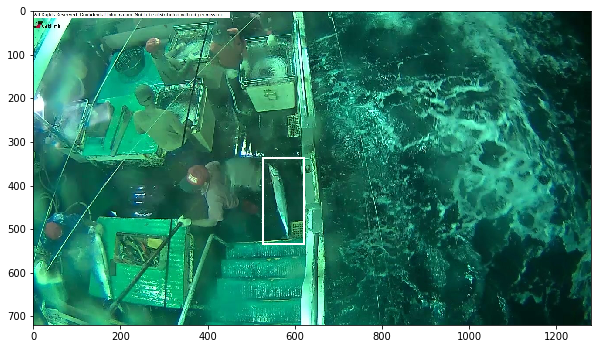

img_07794.jpg ALB


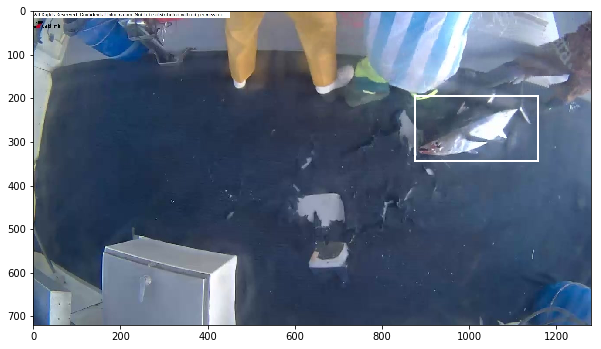

In [16]:
# complete pics
pics = os.listdir(pics_dir)
random.shuffle(pics)
for pic in pics[:2]:
    try:
        print pic, annotations[pic]['ground_truth_label']
        vis_ground_truth(pics_dir+pic,annotations,10,10)
        plt.show()
    except:
        print "Not a Fish!"
        continue

img_02945.jpg ALB


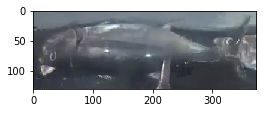

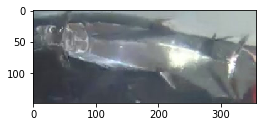

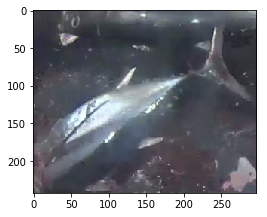

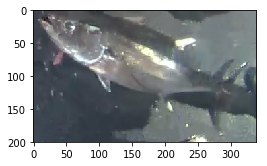

img_07258.jpg Not a Fish!


In [17]:
# cropped pics
pics = os.listdir(pics_dir)
random.shuffle(pics)
for pic in pics[:2]:
    try:
        print pic, annotations[pic]['ground_truth_label']
        vis_crop(pics_dir+pic,annotations,4,10)
        plt.show()
    except:
        print "Not a Fish!"
        continue

### Save annotations for Faster RCNN training

In [19]:
# split train and test data
pics = os.listdir(pics_dir)

seed=42
random.seed(seed)
random.shuffle(pics)
train_size = .95
test_size = 1 - train_size

train_index_stop = int(round(len(pics)*train_size))

train_pics = pics[:train_index_stop]
test_pics = pics[train_index_stop:]

print "Train count: {:,}, Test count: {:,}".format(len(train_pics), len(test_pics))

Train count: 3,588, Test count: 189


In [20]:
# write the test file names to text for easy testing later
test_images_file_name = data_dir+"test_images.txt"
try:
    os.remove(test_images_file_name)
except:
    print "Nothing to delete"
    
with open(test_images_file_name, 'w') as f:
    for pic in test_pics:
        try:
            class_label = annotations[pic]['ground_truth_label']+'/'
            f.write(train_dir+class_label+pic+'\n')
        except:            
            f.write(train_dir+'NoF/'+pic+'\n')

In [22]:
# need to only create xml files for training images
NoF_count = 0
for f in train_pics:
    image_path = pics_dir+f
    try:
        saveXML(image_path,annotations,data_set_name=faster_rcnn_dataset_name,save_dir=annotations_dir)
    except:
        NoF_count+=1
        continue

In [29]:
# Removes the images that had no objects identified within them, thus no .xml file
removed_count = 0
for img in os.listdir(pics_dir):
    name = img.split(".")[0] + '.xml'
    if name not in os.listdir(annotations_dir):
        os.remove(pics_dir+img)
        removed_count+=1
print removed_count

646


In [30]:
# Checking how many images we have for each class
counter = Counter()
for filename in os.listdir(pics_dir):
    counter[annotations[filename]['ground_truth_label']] += 1
            
print counter

Counter({'ALB': 1624, 'YFT': 691, 'OTHER': 284, 'BET': 190, 'SHARK': 169, 'DOL': 113, 'LAG': 60})


In [31]:
# Create the train.txt file for all the images that have annotations
annotations_list = os.listdir(annotations_dir)
train_file = open(staging_dir + 'ImageSets/Main/train.txt',"w")
for file_name in annotations_list:
    name = file_name.split(".")[0]
    train_file.write(name + "\n")
train_file.close()

In [32]:
train_file = open(staging_dir + 'ImageSets/Main/train.txt',"r")

In [33]:
# number of annotated images to train on
print len(train_file.readlines())
train_file.close()

3131


In [34]:
# remove cached pickle file in case the training data has changed (would throw errors when training commences)
try:
    os.remove("/home/ai2-c3p0/Documents/code/todd_working_directory/KaggleFisheries/py-faster-rcnn/data/cache/{}_train_gt_roidb.pkl".format(faster_rcnn_dataset_name))
except:
    print "Nothing to delete"

### Update Faster RCNN Files

##### 1. experiments/scripts/faster_rcnn_end2end.sh

Add these lines in the block of cases (starting in line 25):

Change ITERS number to run more or less iterations

Scroll down to the line that calls train_net.py.

Change the directory of solver.prototxt and initial weights (pre-trained model) files that you want to use.

If you are using the default faster rcnn model, go to models > pascal_voc > VGG16, and copy faster_rcnn_end2end folder which has solver.prototxt, train.prototxt, and test.prototxt.

##### 2. lib/datasets/imagenet_factory.py
In the line 18, change the name variable to reflect what you called TRAIN_IMDB in the previous step.

For example:

##### 3. lib/datasets/imagenet.py
In the init function, change the first line to:

The code above changed:
- function inputs: removed 'year'
- changed the output folder name: it will save the output model to output/faster_rcnn_end2end/kaggle_fishies_train folder
- devkit_path: the directory where you staged your data
- data_path: devkit_path + the name of folder (e.g. Kaggle_Fisheries)
- classes: names of classes you provided in the xml annotation files

##### 4. lib/fast-rcnn/config.py

Change SNAPSHOT_ITERS to how often you want to save the snapshots

##### 5. solver.prototxt

Make sure the train_net is pointing to the correct train.prototxt file.

Change snapshot_prefix to what you want to name the snapshots of the trainig

##### 6. train.prototxt & test.prototxt

If you copied a default one from faster_rcnn:
- search 21, change all of them to your number of classes + 1
- search 84, change all of them to (your number of classes + 1) * 4

##### 7. Running the training script

In terminal, inside of py-faster-rcnn folder, run the command below to start the training on GPU 1:
> ./experiments/scripts/faster_rcnn_end2end.sh 1 VGG16 kaggle_fishies

The snapshots and outputs will be saved in the output/faster_rcnn_end2end/kaggle_fishies_train folder.

The log files will be saved in experiments/logs folder.